 # Modeling Notebook pt. 2
 This is a new notebook to work on modeling the data with neural nets,
 reflecting the specific loss function used by the Databowl challenge. Databowl
 uses a Cumulative Ranked Probability Score (CRPS) to evaluate models, which is
 given by:

 $$
 C = \frac{1}{199N} \sum^N_{m=1} \sum^{99}_{n=-99} (P(y \leq n) - H(n-Y_m))^2
 $$

 where $N$ is the number of samples, $P$ is the predicted probability
 distribution function being evaluated, $Y_m$ is the true number of yards the
 ball was carried on play $m$, and $H$ is the Heaviside step function which is
 0 for negative inputs and 1 for positive inputs.

 What does this evaluate? CRPS is the mean squared difference between two
 cumulative probability distributions: $P$ and $H$. Therefore, we can generate
 the target distribution and then just use MSE as our loss function on a
 regression with 199 outputs. This is a little rough, but the model performs
 relatively well.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split

np.set_printoptions(1)


 Feature engineering has already been done in another notebook, so all we need
 do is import the csv file we created. We index on both game id and play id, so
 we set both of those as the index.

In [2]:
data = pd.read_csv("data/fe_plays_data.csv", index_col=[0,1])
data.dropna(inplace=True)
data.head()


Unnamed: 0   Team      Y     S     A   Dis  \
GameId     PlayId                                                       
2017090700 20170907000118          18   True  30.53  3.63  3.35  0.38   
           20170907000139          40   True  27.16  3.06  2.41  0.34   
           20170907000189          62   True  19.11  5.77  2.42  0.60   
           20170907000345          84   True  25.36  4.45  3.20  0.46   
           20170907000395          98  False  27.12  3.90  2.53  0.44   

                           Orientation     Dir  Season  YardLine  ...  \
GameId     PlayId                                                 ...   
2017090700 20170907000118       198.02  114.26    2017        35  ...   
           20170907000139       149.30   47.80    2017        43  ...   
           20170907000189       219.18  138.04    2017        35  ...   
           20170907000345       173.78   84.56    2017         2  ...   
           20170907000395        34.27  157.92    2017        25  ...   

                           Formation_SINGLEBACK  Formation_WILDCAT  PlayerBMI  \
GameId     PlayId                                                               
2017090700 20170907000118                     0                  0  29.411224   
           20170907000139                     0                  0  29.411224   
           20170907000189                     1                  0  29.411224   
           20170907000345                     0                  0  29.285856   
           20170907000395                     0                  0  30.122595   

                           TimeDelta  PlayerAge  IsRusher  YardsLeft  \
GameId     PlayId                                                      
2017090700 20170907000118        1.0  25.596251      True         35   
           20170907000139        1.0  25.596252      True         43   
           20170907000189        2.0  25.596253      True         65   
           20170907000345        2.0  26.852933      True         98   
           20170907000395        1.0  22.091819      True         25   

                           IsOffense  YardLine_adj  X_adj  
GameId     PlayId                                          
2017090700 20170907000118       True            35  -3.75  
           20170907000139       True            43  -4.07  
           20170907000189       True            65  -3.66  
           20170907000345       True            98  -3.53  
           20170907000395       True            25  -5.01  

[5 rows x 42 columns]

 We have to normalize all the data around its mean in order for the neural
 network to train effectively. We also drop a couple columns that don't contain
 any useful information.

 We define `cdf` to generate the "true" matrix that we will compare against in
 the predicted matrix. We convert all the target values (integer numbers of
 yards) into cumulative probability distributions with the method described by
 the CRPS implementation in the Databowl evaluation page.

In [3]:
data = data.astype(np.float32)
target = data.pop("Yards").astype(np.int)

data.drop(["IsRusher", "IsOffense"], axis=1, inplace=True)
stats = data.describe().transpose()

def norm(x):
    return (x - stats['mean']) / stats['std']

norm_data = norm(data)

def cdf(n):
    return [0]*(99+n) + [1]*(100-n)

target_m = np.array(list(target.map(cdf)))


 We use sklearn to build our KFolds.

In [4]:
x = norm_data.values
y = target_m
x_train, x_test, y_train, y_test = train_test_split(norm_data.values, target_m)


 This distribution-based model (with CRPS loss) is a bit harder to interpret,
 so we establish a baseline to evaluate against. We build this baseline by
 creating a cumulative probability distribution from the distribution of the
 target variable (yards gained on the play).

Baseline MSE: 0.0136


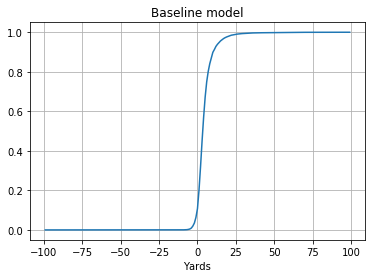

In [5]:
baseline = [(target < i).mean() for i in range(-99, 100)]

y_pred = np.array([baseline] * len(y))
baseline_mse = np.square(y_pred - y).mean()
print(f"Baseline MSE: {baseline_mse:.4f}")

plt.plot(list(range(-99,100)), baseline)
plt.title("Baseline model")
plt.xlabel("Yards")
plt.grid()

plt.show()


 ## Train Model
 This is a relatively simple feed-forward neural network regression that
 produces 199 outputs. Because the CRPS metric is essentially
 mean-squared-error on a probability distribution, we are able to simply use
 the mse metric as long as we generate the target distributions beforehand.

 I would also at some point like to introduce K-fold cross validation in order
 evaluate the performance of the model more effectively.

In [6]:
def compile_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(x.shape[1], name='input'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(199)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

EPOCHS = 50
stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=.00005)
model = compile_model()
history = model.fit(x_train,y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    callbacks=[stop],
    verbose=0
)


 ## Model training performance

loss  val_loss
25  0.012355  0.012045
26  0.012344  0.012047
27  0.012325  0.012014
28  0.012287  0.012042
29  0.012280  0.012041


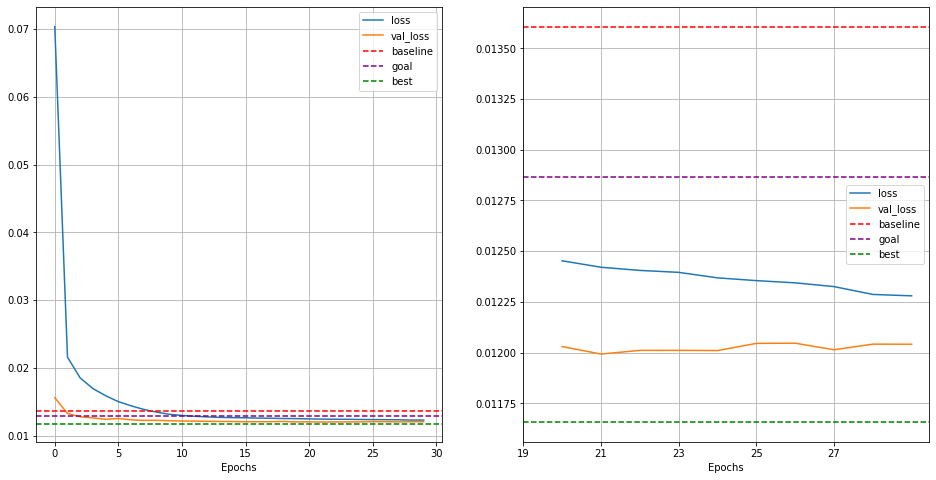

In [7]:
hist = pd.DataFrame(history.history)
fig, ax = plt.subplots(1,2, figsize=(16,8))
goal_mse = 0.012864
best_mse = 0.011658

for start,ax_i in zip([0,-10], ax):
    ax_i.plot(hist.loss[start:], label='loss')
    ax_i.plot(hist.val_loss[start:], label='val_loss')

    ax_i.axhline(baseline_mse, label='baseline', c='red', ls='--')
    ax_i.axhline(goal_mse, label='goal', c='purple', ls='--')
    ax_i.axhline(best_mse, label='best', c='green', ls='--')
    
    ax_i.legend()
    ax_i.grid()

    ax_i.set_xlabel("Epochs")

ax[1].set_xticks(np.arange(start % hist.index.max(), hist.index.max(), 2))

print(hist.tail(5))
fig.show()



 ## Evaluation
 Our primary concern is preventing overfitting, as we have many features and
 not a lot of significant information.

 We can examine the model's performance with a case study, comparing a long, 99
 yard run play

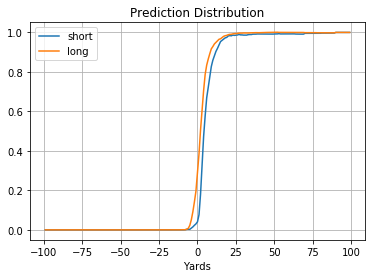

In [8]:
y_pred_long = model.predict(x[20127:20128])[0]
y_pred_short = model.predict(x[:1])[0]


plt.plot(list(range(-99,100)), y_pred_short, label='short')
plt.plot(list(range(-99,100)), y_pred_long, label='long')

plt.title("Prediction Distribution")
plt.xlabel("Yards")
plt.grid()
plt.legend()

plt.show()


 The fact that the predictions for these two plays differ significantly shows
 thour model has some predictive power. Finally, we can check the model's
 performancen the test set that we built earlier.

In [9]:
score = model.evaluate(x_test, y_test)
print(f"Test MSE: {score:.4f}")


7676/7676 [==============================] - 0s 58us/sample - loss: 0.0124
Test MSE: 0.0124
